In [1]:
# set path to compiled vessel module / library
import sys
import time
sys.path.insert(0, 'build/lib/Release/')
sys.path.insert(0, 'build/bin/Release/')
sys.modules.pop('vessel_module', None)  
import vessel_module as vs
print(vs.__file__)
print(dir(vs))

# for visualization
import pyvista as pv
import numpy as np
import os
import random
from collections import deque
from enum import Enum


c:\Users\aettaoui\Desktop\Stage\vessel_synthesizer\build/lib/Release\vessel_module.cp312-win_amd64.pyd
['Domain', 'DomainCircle', 'DomainHalfSphere', 'DomainLines', 'DomainScaling', 'DomainSphere', 'DomainVoxels', 'Forest', 'Node', 'PerfMonitor', 'Settings', 'Synthesizer', 'System', 'SystemSettings', 'Tree', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'not_a_node']


In [108]:
def create_tree_mesh(tree : vs.Tree):
    start, end, radius = tree.segment_data()

    tubes = []
    for (s, e, r) in zip(start, end, radius):
        line = pv.PolyData(np.array([s, e]), lines=np.array([2, 0, 1]))
        tubes.append(line.tube(radius=r))

    if len(tubes) == 0:
        return pv.PolyData()

    return tubes[0].merge(tubes[1:])

def create_tree_line(tree : vs.Tree):
    start, end, radius = tree.segment_data()

    lines = []
    for (s, e, radius) in zip(start, end, radius):
        s_0 = np.array([s[0], s[1], 0])
        e_0 = np.array([e[0], e[1], 0])
        line = pv.Line(s_0, e_0)
        lines.append(line)

    if len(lines) == 0:
        return pv.PolyData()

    return lines[0].merge(lines[1:])


def plot_vascular_tree(tree : vs.Tree, color = "red"):
    p = pv.Plotter()
    p.add_mesh(create_tree_mesh(tree), color=color)
    p.show_grid(xtitle="x", ytitle="y", ztitle="z")
    p.add_axes()
    p.show(jupyter_backend='static')

def plot_vascular_system_screen(*forests : vs.Forest, **kwargs):
    p = pv.Plotter()
    colors = kwargs.get("colors", ["red"])
    repulsivePoints = kwargs.get("repulsivePoints", [])
    rootPoint = kwargs.get("root")
    crossingPointsBifurc = kwargs.get("crossingPointsBifurc")
    crossingPointsSingle = kwargs.get("crossingPointsSingle")
    crossingPointsBifurcNew = kwargs.get("crossingPointsBifurcNew")
    crossingPointsSingleNew = kwargs.get("crossingPointsSingleNew")
    indexScreenshot = kwargs.get("index")

    for index, forest in enumerate(forests):
        trees = forest.trees()
        for tree in trees:
            treeMesh = create_tree_mesh(tree)
            p.add_mesh(treeMesh, color=colors[index])

    for point in repulsivePoints:
        p.add_points(np.array(point), color="blue", point_size=12, render_points_as_spheres=True)

    p0 = np.array(repulsivePoints[0])
    p1 = np.array(rootPoint)

    direction = p1 - p0
    p0 = p0 - direction * 4
    line = pv.Line(p0, rootPoint)
    p.add_mesh(line)

    if crossingPointsBifurc:
        print("B")
        p.add_points(np.array(crossingPointsBifurc), color="green", point_size=5)
    if crossingPointsSingle:
        print("S")
        p.add_points(np.array(crossingPointsSingle), color="black", point_size=5)
    if crossingPointsBifurcNew:
        print("BN")
        p.add_points(np.array(crossingPointsBifurcNew), color="yellow", point_size=5)
    if crossingPointsSingleNew:
        print("SN")
        p.add_points(np.array(crossingPointsSingleNew), color="gray", point_size=5)


    p.show_bounds(location='all', show_zaxis=False, show_zlabels=False)
    p.set_viewup([0, 1, 0])
    p.add_axes()
    p.screenshot(f"C:\\Users\\aettaoui\\Desktop\\Stage\\vessel_synthesizer\\StepByStep\\Try8\\VeinsStep_{indexScreenshot}.png", window_size=[720, 720])

def plot_vascular_system(*forests : vs.Forest, **kwargs):
    p = pv.Plotter(window_size=[512, 512])
    pClots = pv.Plotter(off_screen=True, window_size=[512, 512])

    colors = kwargs.get("colors", ["red"])
    repulsivePoints = kwargs.get("repulsivePoints", [])
    rootPoint = kwargs.get("root")
    crossingPointsBifurc = kwargs.get("crossingPointsBifurc")
    crossingPointsSingle = kwargs.get("crossingPointsSingle")
    crossingPointsBifurcNew = kwargs.get("crossingPointsBifurcNew")
    crossingPointsSingleNew = kwargs.get("crossingPointsSingleNew")
    indexScreenshot = kwargs.get("index")

    repulsiveCircle = pv.Circle(radius=0.08, resolution=100)
    repulsiveCircle.points += np.array(repulsivePoints[0]) 

    rootCircle = pv.Circle(radius=0.025, resolution=100)
    rootCircle.points += np.array(rootPoint)
    p.add_mesh(rootCircle, color="green")
    p.add_mesh(repulsiveCircle, color="blue")
    for index, forest in enumerate(forests):
        treeMesh = []
        trees = forest.trees()

        for tree in trees:
            allPaths = get_thickest_paths(tree, 4, 8)
            for path in allPaths:
                for node in path:
                    circle = pv.Circle(radius=0.01, resolution=100)
                    circle.points += np.array(node.position)
                    #p.add_mesh(circle, color="purple")
            #treeMesh = create_tree_mesh(tree)
            #treeMesh = create_tree_line(tree)
            start, end, radius = tree.segment_data()

            for s, e, r in zip(start, end, radius):
                s_0 = np.array([s[0], s[1], 0])
                e_0 = np.array([e[0], e[1], 0])
                line = pv.Line(s_0, e_0)
                p.add_mesh(line, color=colors[index], line_width=r * 1000)
                #pClots.add_mesh(line, colors[index], line_width=r * 1000, opacity=0)
            #p.add_mesh(treeMesh, color=colors[index])

            #clots = place_central_clots(allPaths, 5)
            #for clot in clots:
            #    circle = pv.Circle(radius=0.01, resolution=100)
            #    circle.points += np.array(clot.position)
            #    p.add_mesh(circle, color="yellow")

    #clots(forests[0], forests[1], p)

    #generate_cases(p, forests[0], forests[1])
    generate_cases(pClots, forests[0], forests[1])
    
    get_veins_artery_intersections(p, forests[0], forests[1])
    #generate_mask(p, forests[0], forests[1], repulsivePoints[0])
    for point in repulsivePoints:
        p.add_points(np.array(point), color="blue", point_size=12, render_points_as_spheres=True)

    p0 = np.array(repulsivePoints[0])
    p1 = np.array(rootPoint)
    
    p.set_viewup([0, 1, 0])
    p.show(jupyter_backend='static')

    #TODO p.screenshot(f"C:\\Users\\aettaoui\\Desktop\\Stage\\vessel_synthesizer\\Planche2\\Planche_{indexScreenshot}.png", window_size=[512, 512])
    p.screenshot(f"C:\\Users\\aettaoui\\Desktop\\Stage\\vessel_synthesizer\\newTextureVesselsOnly.png", window_size=[512, 512])
    pClots.set_viewup([0, 1, 0])
    
    pClots.screenshot(f"C:\\Users\\aettaoui\\Desktop\\Stage\\vessel_synthesizer\\newTextureClotsOnly.png", window_size=[512, 512])

    #pClots.screenshot(f"C:\\Users\\aettaoui\\Desktop\\Stage\\vessel_synthesizer\\newTextureClotsOnly.png", window_size=[512, 512])
    
def save_mesh(forest: vs.Forest, filename):
    mesh = pv.PolyData()

    for tree in forest.trees():
        treeMesh = create_tree_mesh(tree)
        mesh = mesh.merge(treeMesh)

    mesh.save(filename)
    print(f"Mesh saved to {filename}")

def displayMesh(*forests : vs.Forest, **kwargs):
    p = pv.Plotter(off_screen=True)
    index = kwargs.get("index")
    for intdex, forest in enumerate(forests):
        mesh = pv.PolyData()
        meshes = []
        for tree in forest.trees():
            treeMesh = create_tree_mesh(tree)
            mesh = mesh.merge(treeMesh)
            meshes.append(mesh)

            p.add_mesh(mesh, color="red")
    p.set_viewup([0, 1, 0])
    print("Dossier : ", os.getcwd())
    p.close()

def map_hemisphere_screen(*forests : vs.Forest, **kwargs):
    p = pv.Plotter(off_screen=True)
    colors = kwargs.get("colors", ["red"])
    repulsivePoints = kwargs.get("repulsivePoints")
    rootPoint = kwargs.get("root")
    i = kwargs.get("index")
    path = kwargs.get("path")
    radius = 1.0
    meshes = []

    repulsiveCircle = pv.Circle(radius=0.08, resolution=100)
    repulsiveCircle.points += np.array(repulsivePoints[0]) 

    rootCircle = pv.Circle(radius=0.025, resolution=100)
    rootCircle.points += np.array(rootPoint)
    
    for index, forest in enumerate(forests):
        mesh = pv.PolyData()
        meshes = []
        meshes.append(repulsiveCircle)
        meshes.append(rootCircle)

        for tree in forest.trees():
            treeMesh = create_tree_mesh(tree)
            mesh = mesh.merge(treeMesh)
            meshes.append(mesh)

        for mesh in meshes:
            newMesh = mesh.copy()
            X = mesh.points[:, 0]
            Y = mesh.points[:, 1]
            x = 2 * X / (1 + X**2 + Y**2)
            y = 2 * Y / (1 + X**2 + Y**2)
            z = (-1 + X**2 + Y**2) / (1 + X**2 + Y**2)
    
            newPoints = np.vstack([x, y, z]).T
            newMesh.points = newPoints
            print(f"Index: {index}, Color: {colors[index]}")
            p.add_mesh(newMesh, color=colors[index])
        
       
    p.set_viewup([0, 1, 0])
    p.screenshot(path, window_size=[512, 512])

    p.close()

      

# Map the forests and various other meshes onto a hemisph
def map_hemisphere(*forests : vs.Forest, **kwargs):
    p = pv.Plotter(notebook=False)
    colors = kwargs.get("colors", ["red"])
    repulsivePoints = kwargs.get("repulsivePoints")
    rootPoint = kwargs.get("root")
    radius = 1.0
    meshes = []

    repulsiveCircle = pv.Circle(radius=0.08, resolution=100)
    repulsiveCircle.points += np.array(repulsivePoints[0]) 

    rootCircle = pv.Circle(radius=0.025, resolution=100)
    rootCircle.points += np.array(rootPoint)

    line = pv.Line(repulsivePoints[0], rootPoint)

    for index, forest in enumerate(forests):
        mesh = pv.PolyData()
        meshes = []
        meshes.append(repulsiveCircle)
        meshes.append(rootCircle)

        for tree in forest.trees():
            treeMesh = create_tree_mesh(tree)
            mesh = mesh.merge(treeMesh)
            meshes.append(mesh)

        for mesh in meshes:
            newMesh = mesh.copy()
            X = mesh.points[:, 0]
            Y = mesh.points[:, 1]
            x = 2 * X / (1 + X**2 + Y**2)
            y = 2 * Y / (1 + X**2 + Y**2)
            z = (-1 + X**2 + Y**2) / (1 + X**2 + Y**2)
    
            newPoints = np.vstack([x, y, z]).T
            newMesh.points = newPoints
            print(f"Index: {index}, Color: {colors[index]}")
            p.add_mesh(newMesh, color=colors[index])
        
        if index == 0:
            newMesh.save("arteryMappedHalfSphere.ply")
        elif index == 1:
            newMesh.save("venousMappedHalfSphere.ply")

    scaleLine = pv.Line([0, -2, 0], [0.57, -2, 0])
    p.add_mesh(scaleLine, color="black", line_width=3, label="Unités")
    p.add_point_labels(
    points=np.array([[0.5, -2.1, 0]]),  # Position du texte juste en dessous de la ligne
    labels=["10 mm"],
    font_size=10,
    text_color="black"
    )

    p.add_axes()
    p.set_viewup([0, 1, 0])
    p.show(jupyter_backend='pythreejs')

    
def add_clots(forest, clotsCount):
    mesh = pv.PolyData()
    meshes = []

    for tree in forest.trees():
        treeMesh = create_tree_mesh(tree)
        mesh = mesh.merge(treeMesh)
        meshes.append(mesh)
    
    points = np.vstack([mesh.points for mesh in meshes])

    X = points[:, 0]
    Y = points[:, 1]
    
    print(f"X : {X}")
    print(f"Y : {Y}")

    clotsIndices = []
   
    indices = [i for i, _ in enumerate(X)]
    for i in range(clotsCount):
        x = random.choice(indices)
        clotsIndices.append(x)

    clotsPos = [points[i] for i in clotsIndices]

    return clotsPos

def add_clots_nodes(forest, clotsCount):
    positions = []
    randomPositions = []

    for tree in forest.trees():
        tree.breadth_first(
            lambda node: positions.append(node.position) if not node.is_leaf() else None)
    
    if positions is not None:
        for i in range(clotsCount):
            randomPositions.append(random.choice(positions))
    
        return randomPositions
    
    else:
        return []

def count_leafs_internodes(forest):
    allNodes = []
    leafsCount = 0
    internodesCount = 0

    for tree in forest.trees():
        tree.breadth_first(
            lambda node: allNodes.append(node))
        
    for node in allNodes:
        if node.is_leaf():
            leafsCount += 1
        elif node.is_inter():
            internodesCount += 1

    print(f"Leaf count : {leafsCount}")
    print(f"Internodes count : {internodesCount}")

def allPathsRadii(tree, node, path):
    path = path + [node]

    if all(child == vs.not_a_node for child in node.children):
        return [path]

    paths = []
    for childId in node.children:
        if childId != vs.not_a_node:
            child = tree.get_node(childId)
            paths.extend(allPathsRadii(tree, child, path))
    return paths

def get_thickest_paths(tree, n, discriminant):
    root = tree.get_root()

    allPaths = allPathsRadii(tree, root, [])

    weightedPaths = []
    for path in allPaths:
        sumRadii = 0
        for node in path:
            sumRadii += node.radius

        weightedPaths.append((path, sumRadii))
    
    weightedPaths.sort(reverse=True, key= lambda x : x[1])

    selectedPaths = []
    for path, _ in weightedPaths:
        if any(is_path_similar(path, alreadySelected, discriminant) for alreadySelected in selectedPaths):
            continue
        selectedPaths.append(path)

        if len(selectedPaths) >= n:
            break

    return selectedPaths 

def is_path_similar(path1, path2, discriminant):
    minLength = min(len(path1), len(path2))

    commonNodesCount = 0

    for i in range(minLength):
        if path1[i].id == path2[i].id:
            commonNodesCount += 1
        else:
            break
    
    return commonNodesCount >= discriminant

def place_branch_clots(tree, centralPaths, clotsCount):
    centralNodes = set(node.id for path in centralPaths for node in path)
    allNodes = []

    tree.breadth_first(
        lambda node: allNodes.append(node))
        
    branchNodes = [node for node in allNodes if node.id not in centralNodes]

    bifurcatingNodes = [node for node in branchNodes if 
                        sum(1 for child in node.children if child != vs.not_a_node) == 2]

    if clotsCount > len(bifurcatingNodes):
        clotsCount = len(bifurcatingNodes) - 1

    clots = random.sample(bifurcatingNodes, clotsCount)

    return clots

def place_central_clots(tree, centralPaths, clotsCount):
    randomPath = random.choice(centralPaths)

    # Get only the first few nodes because it's supposed to be close to the optic nerve
    randomPath = randomPath[2:10]

    # Get either nodes that bifurcate
    bifurcatingNodes = [node for node in randomPath if 
                        sum(1 for child in node.children if child != vs.not_a_node) == 2]

    # or nodes that intersects with artery/vein
    # intersectingNodes = ...

    # Mix them together 
    # ...

    # And pick randomly
    if clotsCount > len(bifurcatingNodes):
        clotsCount = len(bifurcatingNodes) - 1
    clots = random.sample(bifurcatingNodes, clotsCount)
    
    return clots 

def clots(forestA, forestV, plot, radius):
    treeArteries = forestA.trees()[0]
    treeVeins = forestV.trees()[0]
    clots = []

    centralPathsArteries = get_thickest_paths(treeArteries, 4, 9)
    centralPathsVeins = get_thickest_paths(treeVeins, 4, 9)

    color = ""
    casesProbaRAO = {
        "CRAO":0.06,
        "BRAO":0.08,
    }

    casesProbaRVO = {
        "CRVO":0.28,
        "BRVO":0.45
    }

    # How many cases we're going to generate (only CRAO or BRAO + CRVO or etc.)
    randomCaseCount = random.randint(1,4)
    print(f"Selecting {randomCaseCount} cases")
    # Get a random case between CRAO, BRAO, CRVO, BRVO
    randomCases = []

    for i in range(randomCaseCount):
        probability = random.random()
        print(f"Probability : {probability}")
        # RVO
        if probability >= 0.25:
            # choices returns a list, we only want one element anyway
            caseType = random.choices(
                population=list(casesProbaRVO.keys()),
                weights=list(casesProbaRVO.values()),
                k=1
            )[0]
        # RAO
        else:
            caseType = random.choices(
                population=list(casesProbaRAO.keys()),
                weights=list(casesProbaRAO.values()),
                k=1
            )[0]
        
        randomCases.append(caseType)
    for caseIndex in randomCases:
        match caseIndex:
            case "CRAO":
                clotCount = random.randint(1, 2)
                print(f"CRAO selected with {clotCount} node(s)")
                clots = place_central_clots(treeArteries, centralPathsArteries, clotCount)
                color = "yellow"
                add_circles_to_plot(plot, clots, color, radius)
            case "BRAO":
                clotCount = random.randint(1, 2)
                print(f"BRAO selected with {clotCount} node(s)")
                clots = place_branch_clots(treeArteries, centralPathsArteries, clotCount)
                color = "brown"
                add_circles_to_plot(plot, clots, color, radius)
            case "CRVO":
                clotCount = random.randint(1, 2)
                print(f"CRVO selected with {clotCount} node(s)")
                clots = place_central_clots(treeVeins, centralPathsVeins, clotCount)
                color = "orange"
                add_circles_to_plot(plot, clots, color, radius)
            case "BRVO":
                clotCount = random.randint(1, 2)
                print(f"BRVO selected with {clotCount} node(s)")
                positions, minRadii = place_clots_intersection(plot, forestA, forestV, centralPathsVeins, clotCount)
                #clots = place_branch_clots(treeVeins, centralPathsVeins, clotCount)
                color = "grey"
                add_positions_to_plot(plot, positions, color, minRadii)

    return clots

def add_circles_to_plot(plot, clots, color, radius):
    for clot in clots:
        circle = pv.Circle(radius=clot.radius * 2, resolution=100)
        circle.points += np.array(clot.position) + np.array([0.0, 0.0, 0.02])

        secondCircleOffseted = pv.Circle(radius=radius + 0.1, resolution=100)
        secondCircleOffseted.points+= np.array(clot.position) + np.array([0.0, 0.0, 0.01])
        #plot.add_mesh(secondCircleOffseted, color=color)
        
        plot.add_mesh(circle, color="orange")

def add_positions_to_plot(plot, positions, color, radii):
    for position, radius in zip(positions, radii):
        newPosition = (position[0], position[1], 0.02)
        circle = pv.Circle(radius=radius * 2, resolution=100)
        circle.points += np.array(newPosition)
        
        secondCircleOffseted = pv.Circle(radius=radius + 0.1, resolution=100)
        secondCircleOffseted.points+= np.array(newPosition) + np.array([0.0, 0.0, 0.01])
        #plot.add_mesh(secondCircleOffseted, color=color)
        print(f"[BRVO I Guess] Adding colored circle in position {newPosition}")
        plot.add_mesh(circle, color="lime")

      

# The idea is to look at the segments as :
# AB = A + alpha*AB, 0 <= alpha <= 1
# CD = C + beta*CD, 0 <= beta <= 1
# If we find values of alpha and beta that match the same point 
# it intersects
def get_intersect_point(A, B, C, D):
    x1, y1 = A[:2]
    x2, y2 = B[:2]
    x3, y3 = C[:2]
    x4, y4 = D[:2]

    denom = (x4 - x3)*(y2 - y1) - (y4 - y3)*(x2 - x1)
    if denom == 0:
        return None

    alpha = ((x4 - x3)*(y3 - y1) - (y4 - y3)*(x3 - x1)) / denom
    beta = ((x2 - x1)*(y3 - y1) - (y2 - y1)*(x3 - x1)) / denom

    if alpha >= 0 and alpha <= 1 and beta >= 0 and beta <= 1:
        x0 = x1 + alpha*(x2 - x1) 
        y0 = y1 + alpha*(y2 - y1) 

        return (x0, y0)
    
    return None

def get_min_radius(nodes):
    minRadius = 100000000000
    for node in nodes:
        if node.radius < minRadius:
            minRadius = node.radius

    return minRadius

def get_veins_artery_intersections(plot, forestArteries, forestVeins):
    allSegmentsArteries = []
    allSegmentsVeins = []
    allIntersections = []

    treeArteries = forestArteries.trees()[0]
    treeVeins = forestVeins.trees()[0]

    treeArteries.breadth_first(
        lambda node: allSegmentsArteries.extend(
            [(node, treeArteries.get_node(childId))
            for childId in node.children if childId != vs.not_a_node
        ])
    )

    treeVeins.breadth_first(
        lambda node: allSegmentsVeins.extend(
            [(node, treeVeins.get_node(childId))
            for childId in node.children if childId != vs.not_a_node
        ])
    )

    for node1, node2 in allSegmentsArteries:
        for nodeA, nodeB in allSegmentsVeins:
            intersection = get_intersect_point(
                np.array(node1.position),
                np.array(node2.position),
                np.array(nodeA.position),
                np.array(nodeB.position)
            )

            if intersection is not None:
                allIntersections.append(((node1, node2, nodeA, nodeB), intersection))
                #circle = pv.Circle(radius=0.01, resolution=100)
                #intersection3D = np.array([intersection[0], intersection[1], 0])
                #circle.points += np.array(intersection3D)
                #plot.add_mesh(circle, color="pink")

    return allIntersections

def place_clots_intersection(plot, forestArteries, forestVeins, centralNodes, clotsCount):
    allIntersections = get_veins_artery_intersections(plot, forestArteries, forestVeins)
    isCentralNode = True
    clots = []
    minRadii = []

    allRadii = [get_min_radius(nodes) for nodes, _ in allIntersections]
    minRadiusAllowed = np.percentile(allRadii, 25)

    for i in range(clotsCount):
        while isCentralNode:
            isCentralNode = False
            randomIndex = random.randint(0, len(allIntersections) - 1)
            currentNodes, intersection = allIntersections[randomIndex]
            for node in currentNodes:
                if node in centralNodes:
                    isCentralNode = True

            minRadius = get_min_radius(currentNodes)
            if minRadius < minRadiusAllowed:
                isCentralNode = True
        
        minRadii.append(minRadius)
        clots.append(intersection)
        isCentralNode = True
    print(f"Intersections : {clots}")
    return clots, minRadii

def call_generate_mask(forestA, forestV, macula):
    plot = pv.Plotter()

    generate_mask(plot, forestA, forestV, macula)

    plot.set_viewup([0, 1, 0])

    plot.screenshot(f"C:\\Users\\aettaoui\\Desktop\\Stage\\vessel_synthesizer\\mask.png", window_size=[1024, 1024])

    plot.show(jupyter_backend='static')

def generate_cases(plot, forestA, forestV):
    treeA = forestA.trees()[0]
    treeV = forestV.trees()[0]
    allNodes = []
    root = treeA.get_root()
    treeA.breadth_first(
        lambda node: allNodes.append(node)
    )

    treeV.breadth_first(
        lambda node: allNodes.append(node)
    )

    clots(forestA, forestV, plot, 0.05)

def get_percentile(nodes, percentile):
    return np.percentile([node.radius for node in nodes], percentile)

def generate_mask(plot, forestA, forestV, macula):
    treeA = forestA.trees()[0]
    treeV = forestV.trees()[0]
    allNodes = []
    root = treeA.get_root()
    treeA.breadth_first(
        lambda node: allNodes.append(node)
    )

    treeV.breadth_first(
        lambda node: allNodes.append(node)
    )
    
    add_circles_to_plot(plot, allNodes, "red", 0.05)

    add_positions_to_plot(plot, [macula], "blue", 0.15)

    add_circles_to_plot(plot, [root], "green", 0.15)

    clots(forestA, forestV, plot, 0.05)


In [108]:
import numpy as np
import matplotlib.pyplot as plt
import math

def computeConvolutionSurface(forest: vs.Forest, path, threshold, gridX, gridY):
    # Create our field (points p)
    horizontalGrid = np.linspace(-1, 1, gridX)
    verticalGrid = np.linspace(-1, 1, gridY)
    
    grid = np.meshgrid(horizontalGrid, verticalGrid)
    f = np.zeros_like(grid[0])
    for tree in forest:
        # Get our skeleton start and end points (S)
        starts, ends, radius = tree.segment_data()
        for i in range(len(starts)):
            start = starts[i]
            end = ends[i]
            # Discretize the segment as a spline
            discretizedSpace = np.linspace(0, 1, 20) 
            for t in discretizedSpace:
                s = (1-t)*start[:2] + t *end[:2] 
                squaredDist = (s[0] - grid[0])**2 + (s[1] - grid[1]) ** 2
                if radius[i] < threshold:
                    continue
                f += np.exp(-squaredDist / (2* radius[i] * 0.01))

    newF = f > 5
    plt.imshow(f)
    plt.imsave(path, f)
    plt.show()


In [5]:
# N generations in a folder, where we can decide to keep / regenerate them
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points

forests = []

def generateVessels(domain, repulsivePoints, root, index):
    domain.seed(index)

    for point in repulsivePoints:
        domain.add_repulsive_points(point)
    # create synthesizer object for domain
    synth = vs.Synthesizer(domain)

    # modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
    synth.settings.steps = 100
    #synth.settings.steps = 300
    synth.settings.scale(1.5)

    # set root note of tree (or use set_forest(...)) to grow from intial trees
    synth.create_root(vs.System.ARTERIAL, root)
    synth.run()

    # get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
    forestA = synth.get_arterial_forest()

    synth.create_root(vs.System.VENOUS, root)
    synth.run()
    forestV = synth.get_venous_forest()

    forests.append((forestA, forestV))

    colors_ = ["red", "blue"]

    path = f"C:\\Users\\aettaoui\\Desktop\\Stage\\vessel_synthesizer\\Planche4\\Planche_{index}.png"
    map_hemisphere_screen(forestA, forestV, colors=colors_, repulsivePoints=repulsivePoints, root=root, index=index, path=path)

n = 5
circle = vs.DomainCircle([0.0, 0, 0], 1, [1.0, 0.0, 0.0], 0.3, 10, 85, 30)
repulsivePoints = [[0.07, 0.0, 0.0]]
root = [0.35, 0.0, 0.0]
for i in range(n):
    generateVessels(circle, repulsivePoints, root, i)

x = 'a'
while True:
    print('Regenerate ? [index] : ')
    x = input()
    if x == 'c':
        break

    print('Regenerating index, ' + x) 
    generateVessels(circle, repulsivePoints, root, int(x))



Index: 0, Color: red
Index: 0, Color: red
Index: 0, Color: red
Index: 1, Color: blue
Index: 1, Color: blue
Index: 1, Color: blue
Index: 0, Color: red
Index: 0, Color: red
Index: 0, Color: red
Index: 1, Color: blue
Index: 1, Color: blue
Index: 1, Color: blue
Index: 0, Color: red
Index: 0, Color: red
Index: 0, Color: red
Index: 1, Color: blue
Index: 1, Color: blue
Index: 1, Color: blue
Index: 0, Color: red
Index: 0, Color: red
Index: 0, Color: red
Index: 1, Color: blue
Index: 1, Color: blue
Index: 1, Color: blue
Index: 0, Color: red
Index: 0, Color: red
Index: 0, Color: red
Index: 1, Color: blue
Index: 1, Color: blue
Index: 1, Color: blue
Regenerate ? [index] : 
Regenerating index, 0
Index: 0, Color: red
Index: 0, Color: red
Index: 0, Color: red
Index: 1, Color: blue
Index: 1, Color: blue
Index: 1, Color: blue
Regenerate ? [index] : 


In [3]:
# Step by step
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
circle = vs.DomainCircle([0.0, 0, 0], 1, [1.0, 0.0, 0.0], 0.25, 10)
index = 2
circle.seed(index)
repulsivePoints = [[0.07, 0.0, 0.0]]

for point in repulsivePoints:
    circle.add_repulsive_points(point)
# create synthesizer object for domain
synth = vs.Synthesizer(circle)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 100
#synth.settings.steps = 300
synth.settings.scale(1.5)

root = [0.35, 0.0, 0.0]
#root = [0.0, 0.0, 0.0]
# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, root)
synth.run()

forestA = synth.get_arterial_forest()

synth.init()
synth.create_root(vs.System.VENOUS, [0.35, 0.0, 0.0])
p = pv.Plotter()

for i in range(100):
    synth.step_by_step()
    forestV = synth.get_venous_forest()
    colors_ = ["red", "blue"]

    crossingPointsBifurc = circle.get_crossing_points_bifurc()
    crossingPointsSingle = circle.get_crossing_points_single()
    crossingPointsBifurcNew = circle.get_crossing_points_bifurc_new()
    crossingPointsSingleNew = circle.get_crossing_points_single_new()

    plot_vascular_system_screen(forestA, forestV, colors=colors_, repulsivePoints=repulsivePoints, root=root, crossingPointsBifurc=crossingPointsBifurc, crossingPointsSingle=crossingPointsSingle,
                     crossingPointsBifurcNew=crossingPointsBifurcNew, crossingPointsSingleNew=crossingPointsSingleNew, index=i)
    
    time.sleep(0.1)

print(circle.dump_logs())

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. vessel_module.DomainCircle(arg0: vec3, arg1: float, arg2: vec3, arg3: float, arg4: int, arg5: int)

Invoked with: [0.0, 0, 0], 1, [1.0, 0.0, 0.0], 0.25, 10

Leaf count : 303
Internodes count : 607
Selecting 2 cases
Probability : 0.05102689277772776
Probability : 0.7449071560466571
BRAO selected with 2 node(s)
CRVO selected with 1 node(s)


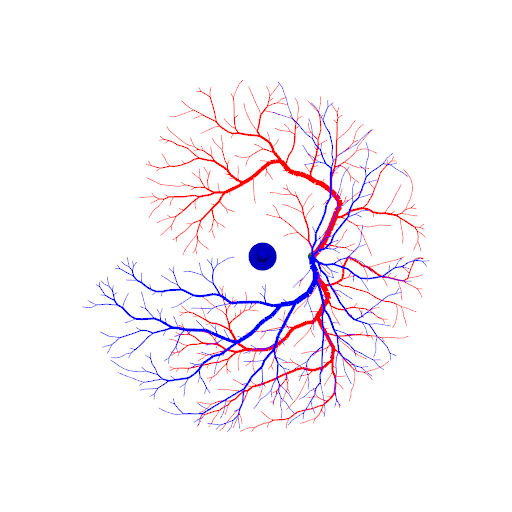

In [109]:
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
circle = vs.DomainCircle([0.0, 0, 0], 1, [1.0, 0.0, 0.0], 0.3, 10, 85, 30)

index = 11
circle.seed(index)
repulsivePoints = [[0.07, 0.0, 0.0]]

for point in repulsivePoints:
    circle.add_repulsive_points(point)
# create synthesizer object for domain
synth = vs.Synthesizer(circle)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 100
#synth.settings.steps = 300
synth.settings.scale(1.5)

root = [0.35, 0.0, 0.0]
#root = [0.0, 0.0, 0.0]
# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, root)
synth.run()

# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forestA = synth.get_arterial_forest()

synth.create_root(vs.System.VENOUS, [0.35, 0.0, 0.0])
#synth.create_root(vs.System.VENOUS, [0.0, 0.0, 0.0])
synth.run()
forestV = synth.get_venous_forest()
colors_ = ["red", "blue"]

crossingPointsBifurc = circle.get_crossing_points_bifurc()
crossingPointsSingle = circle.get_crossing_points_single()
crossingPointsBifurcNew = circle.get_crossing_points_bifurc_new()
crossingPointsSingleNew = circle.get_crossing_points_single_new()

#map_hemisphere_screen(forestA, forestV, colors=colors_, repulsivePoints=repulsivePoints, root=root, index=index)
print(forestA)

count_leafs_internodes(forestA)

#add_clots(forestA, 5)
#plot_vascular_system(forestA, forestV, colors=colors_, repulsivePoints=repulsivePoints)
plot_vascular_system(forestA, forestV, colors=colors_, repulsivePoints=repulsivePoints, root=root, crossingPointsBifurc=crossingPointsBifurc, crossingPointsSingle=crossingPointsSingle,
                     crossingPointsBifurcNew=crossingPointsBifurcNew, crossingPointsSingleNew=crossingPointsSingleNew, index=0)

#call_generate_mask(forestA, forestV, repulsivePoints[0])

#map_hemisphere(forestA, forestV, colors=colors_, repulsivePoints=repulsivePoints, root=root, index=index)



In [46]:
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
circle = vs.DomainCircle([0.0, 0, 0], 1, [1.0, 0.0, 0.0], 0.5)

index = 0
circle.seed(index)
repulsivePoints = [[0.07, 0.0, 0.0]]

for point in repulsivePoints:
    circle.add_repulsive_points(point)
# create synthesizer object for domain
synth = vs.Synthesizer(circle)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 100
synth.settings.scale(1.5)

#root = [0.0, 0.0, 0.0]
root = [0.35, 0.0, 0.0]
# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, root)
synth.run()

# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forestA = synth.get_arterial_forest()

synth.create_root(vs.System.VENOUS, [0.35, 0.0, 0.0])
synth.run()
forestV = synth.get_venous_forest()

computeConvolutionSurface(forestA, "choroidVesselsVeinous2.png")


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. vessel_module.DomainCircle(arg0: vec3, arg1: float, arg2: vec3, arg3: float, arg4: int, arg5: int, arg6: int)

Invoked with: [0.0, 0, 0], 1, [1.0, 0.0, 0.0], 0.5

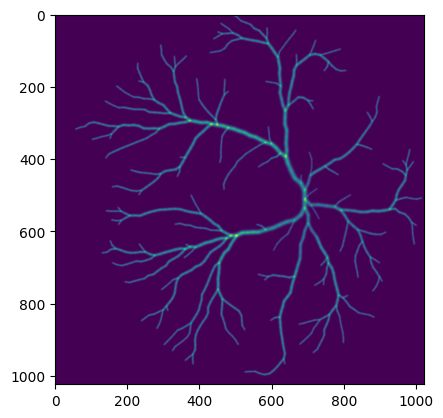

In [9]:
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
circle = vs.DomainCircle([0.0, 0, 0], 1, [1.0, 0.0, 0.0], 0.5)
index = 0
circle.seed(index)
repulsivePoints = [[0.07, 0.0, 0.0]]

for point in repulsivePoints:
    circle.add_repulsive_points(point)
# create synthesizer object for domain
synth = vs.Synthesizer(circle)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 100
synth.settings.scale(1.5)

root = [0.35, 0.0, 0.0]
# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, root)
synth.run()


# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forestA = synth.get_arterial_forest()

synth.create_root(vs.System.VENOUS, [0.35, 0.0, 0.0])
synth.run()
forestV = synth.get_venous_forest()

computeConvolutionSurface(forestA, "choroidVesselsA4.png", 0.0008, 1024, 1024)
#computeConvolutionSurface(forestV, "choroidVesselsV5.png", 0.0008, 1024, 1024)


In [32]:
halfSphere = vs.DomainHalfSphere([0, 0, 0], 0.5)

synth = vs.Synthesizer(halfSphere)

synth.settings.steps = 100
synth.settings.scale(1.5)

synth.create_root(vs.System.ARTERIAL, [0.0, 0.0, 0.0])
synth.run()

# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forestA = synth.get_arterial_forest()

print(halfSphere.dump_logs())
colors_ = ["red", "blue"]
plot_vascular_system(forestA, colors=colors_)


Test domainx:  -0.403553y:  -0.267217z:  -0.125460
x:  -0.145048y:  0.160679z:  0.450714
x:  -0.412447y:  -0.161450z:  0.231994
x:  0.169800y:  0.459820z:  0.098659
x:  0.282004y:  -0.228365z:  -0.343981
x:  0.112236y:  0.345056z:  -0.344005
x:  0.203897y:  -0.114612z:  -0.441916
x:  -0.168839y:  -0.295649z:  0.366176
x:  -0.109020y:  0.477379z:  0.101115
x:  -0.145313y:  0.430801z:  0.208073
x:  0.107782y:  0.092433z:  -0.479416
x:  -0.160368y:  0.058880z:  0.469910
x:  0.267556y:  -0.260568z:  0.332443
x:  0.408944y:  0.004002z:  -0.287661
x:  0.383854y:  -0.037689z:  -0.318175
x:  0.036509y:  0.385272z:  -0.316595
x:  0.076805y:  0.453630z:  -0.195758
x:  0.497419y:  0.044286z:  0.024756
x:  0.474690y:  0.141556z:  -0.068055
x:  0.432488y:  0.139171z:  -0.208771
x:  0.149783y:  -0.463739z:  0.111853
x:  0.288577y:  0.191725z:  -0.360506
x:  0.430241y:  -0.147271z:  -0.207855
x:  -0.470562y:  0.103500z:  -0.133638
x:  0.208626y:  0.452267z:  -0.043930
x:  0.034095y:  0.409282z:  0.28

ValueError: Empty meshes cannot be plotted. Input mesh has zero points. To allow plotting empty meshes, set `pv.global_theme.allow_empty_mesh = True`

In [107]:
# Conjonctive

# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
circle = vs.DomainCircle([0.0, 0, 0], 3, [1.0, 0.0, 0.0], 0.5)
#sphere.sample()
#print(f"Allloooo : {circle.logs}")
circle.seed(4)
repulsivePoints = [[0.0, 0.0, 0.0]]#, [0.0, -0.51, 0.0]]#, [0.0, -0.49, 0.0]]#, [0.0, -0.495, 0.0], [0.0, -0.505, 0.0], [0.0, -0.493, 0.0]]

for point in repulsivePoints:
    circle.add_repulsive_points(point)
# create synthesizer object for domain
synth = vs.Synthesizer(circle)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 150
synth.settings.scale(1.5)

root = [0.0, 0.0, 0.0]
# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, root)
synth.run()

#print(circle.dump_logs())

# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forestA = synth.get_arterial_forest()

synth.create_root(vs.System.VENOUS, [0.4, 0.0, 0.0])
synth.run()
forestV = synth.get_venous_forest()
colors_ = ["red", "blue"]
#plot_vascular_system(forestA, forestV, colors=colors_, repulsivePoints=repulsivePoints)
#save_mesh(forestA, "arteryPlane.ply")
#save_mesh(forestV, "venousPlane.ply")
displayMesh(forestA, forestV)
#map_hemisphere(forestA, forestV, colors=colors_, repulsivePoints=repulsivePoints, root=root)

#save_mesh(forestA, "goodVessels.ply")



TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. vessel_module.DomainCircle(arg0: vec3, arg1: float, arg2: vec3, arg3: float, arg4: int, arg5: int, arg6: int)

Invoked with: [0.0, 0, 0], 3, [1.0, 0.0, 0.0], 0.5

In [6]:
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
sphere = vs.DomainSphere([0.0, 0, 0], 0.5)

# create synthesizer object for domain
synth = vs.Synthesizer(sphere)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 35
synth.settings.scale(1.5)

# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, [0.0, 0.0, 0.0])
synth.run()

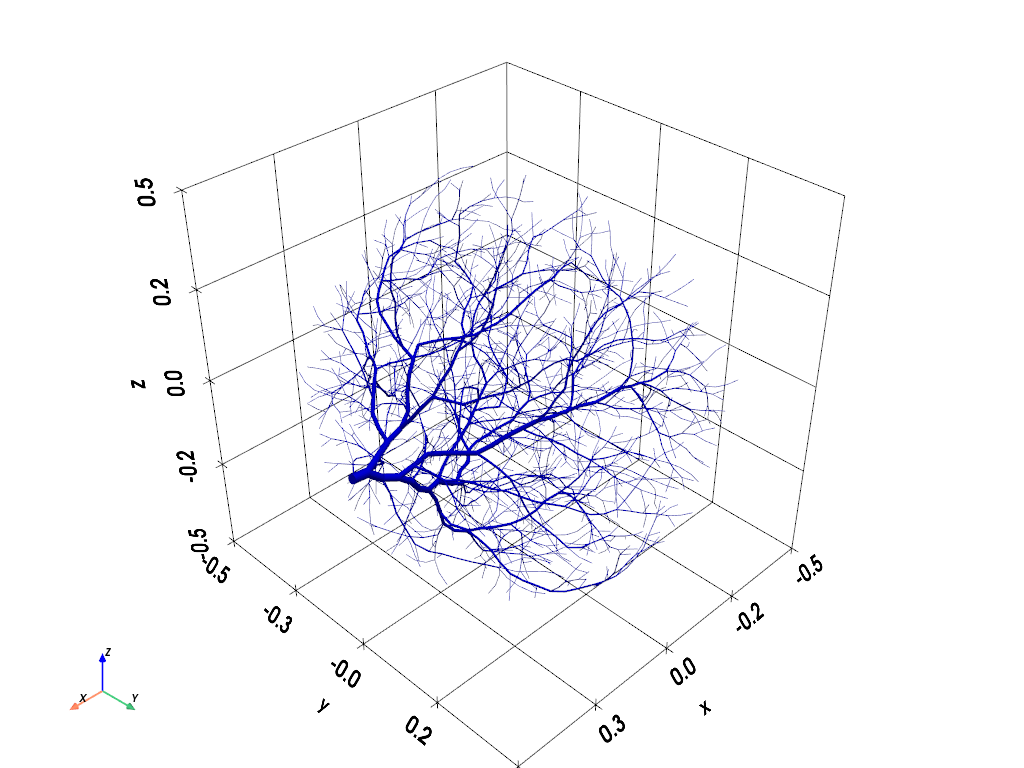

In [7]:
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
sphere = vs.DomainSphere([0.0, 0, 0], 0.5)

# create synthesizer object for domain
synth = vs.Synthesizer(sphere)
# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 35
synth.settings.scale(1.5)

# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, [0.5, 0.0, 0.0])
synth.run()

# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forest = synth.get_arterial_forest()
#save_mesh(forest, 'arteryMeshSphere.ply')
#print(f"Test : {sphere.logs}")
# show developed vascular structure
plot_vascular_system(forest, "blue")

Allloooo : 


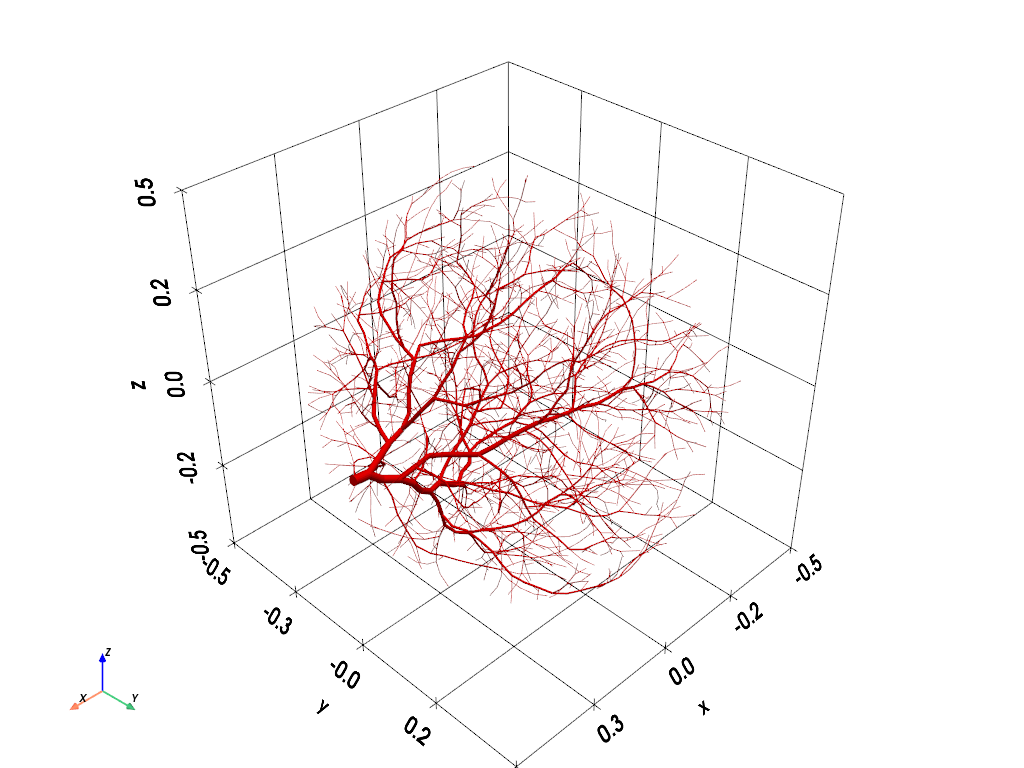

In [4]:
# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forest = synth.get_arterial_forest()
print(f"Allloooo : {sphere.dump_logs("")}")

# show developed vascular structure
plot_vascular_system(forest, "red")

Mesh saved to retinaArtery.ply


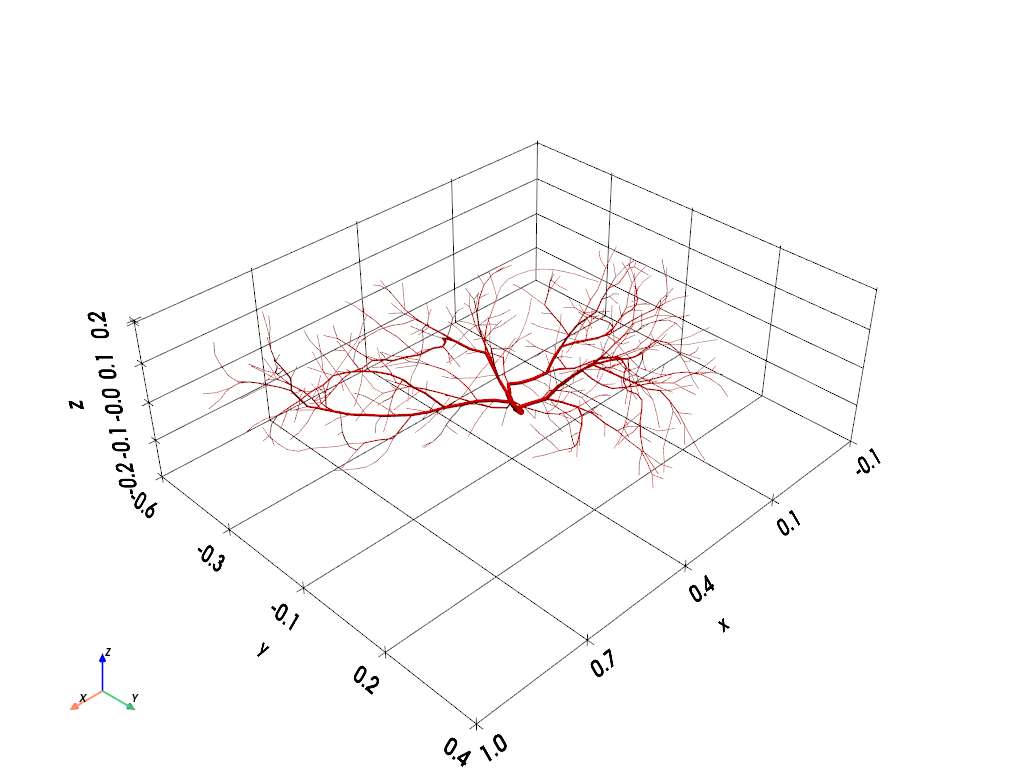

: 

In [ ]:
# Define initial lines
line = vs.DomainLines([[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
                       [[2, -1, 0], [2, 1, 0], [2, -1, 0], [-2, -1, 0]], 
                       0.2)

synth = vs.Synthesizer(line)

synth.settings.steps = 35
synth.settings.scale(1.5)

synth.create_root(vs.System.ARTERIAL, [0.5, 0.0, 0.0])
synth.run()

# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forest = synth.get_arterial_forest()
save_mesh(forest, 'retinaArtery.ply')

# show developed vascular structure
plot_vascular_system(forest, "red")

In [7]:
# Define initial lines
line = vs.DomainLinesHalfSphere([0.0, 0, 0], 0.5, 
                        [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
                       [[1, 0, 0], [1, 1, 0], [1, -1, 0], [-1, 0, 0]], 
                       0.2)

synth = vs.Synthesizer(line)

synth.settings.steps = 35
synth.settings.scale(1.5)

synth.create_root(vs.System.ARTERIAL, [0.5, 0.0, 0.0])
synth.run()

# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forest = synth.get_arterial_forest()
save_mesh(forest, 'retinaArtery.ply')

# show developed vascular structure
plot_vascular_system(forest, "red")

AttributeError: module 'vessel_module' has no attribute 'DomainLinesHalfSphere'

: 

In [ ]:
# define domain in which vessels should grow; can be = DomainCircle, DomainSphere, DomainLines, DomainVoxels
# -> boundaries are not strictly enforced; it just defines locations of samples for attraction points
circle = vs.DomainCircle([0.0, 0, 0], 1, [1.0, 0.0, 0.0], 0.5)
#sphere.sample()
#print(f"Allloooo : {circle.logs}")
circle.seed(11)
repulsivePoints = [[0.0, -0.5, 0.0]]#, [0.0, -0.51, 0.0]]#, [0.0, -0.49, 0.0]]#, [0.0, -0.495, 0.0], [0.0, -0.505, 0.0], [0.0, -0.493, 0.0]]

for point in repulsivePoints:
    circle.add_repulsive_points(point)
#circle.add_repulsive_points([0.0, 0.0, 0.0])
#circle.add_repulsive_points([0.0, -0.5, 0.0])
#circle.add_repulsive_points([0.0, -0.55, 0.0])
##circle.add_repulsive_points([0.0, -0.6, 0.0])
#circle.add_repulsive_points([0.0, -0.45, 0.0])
#circle.add_repulsive_points([0.0, -0.47, 0.0])
# create synthesizer object for domain
synth = vs.Synthesizer(circle)

# modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
synth.settings.steps = 135
synth.settings.scale(1.5)

# set root note of tree (or use set_forest(...)) to grow from intial trees
synth.create_root(vs.System.ARTERIAL, [0.0, 0.0, 0.0])
synth.run()

print(circle.dump_logs())

# get arterial trees (this gives you a copy of the trees; any changes will not affect the trees stored in the synthesizer)
forestA = synth.get_arterial_forest()
#
##synth.create_root(vs.System.ARTERIAL, [1.0, 0.0, 0.0])
##synth.run()
##
##forestB = synth.get_arterial_forest()
#
#synth.create_root(vs.System.VENOUS, [0.0, 0.0, 0.0])
#synth.run()
#forestV = synth.get_venous_forest()


#synth3 = vs.Synthesizer(sphere)
#
## modify settings (these are highly dependent on the dimensions of the domain, use scale to find an initial setup where things work)
#synth3.settings.steps = 35
#synth3.settings.scale(1.5)
#
#synth3.create_root(vs.System.ARTERIAL, [0.0, 0.0, 0.0])
#synth3.run()
#forestB = synth3.get_arterial_forest()
#
#
#synth3.create_root(vs.System.VENOUS, [0.0, 0.0, 0.0])
#synth3.run()
#forestC = synth3.get_venous_forest()
#save_mesh(forest, 'arteryMeshCircle.ply')

#with open("debug_log.txt", "r") as f:
#    print(f.read())

# show developed vascular structure
#plot_vascular_system(forestA, forestV)
plot_vascular_system(forestA, repulsivePoints=repulsivePoints)

#plot_vascular_system(forestV, "blue")